 <img src="https://mma.prnewswire.com/media/809139/Fractal_Analytics_Logo.jpg?p=publish&w=200"/>

## Boston Home Prices Regression - Cross Validation Example

#### Load Modules

In [1]:
from functools import reduce
import itertools
import collections
import datetime
from IPython.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets
import time
import warnings
warnings.filterwarnings('ignore')

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

#### Define Functions

In [2]:
def unnest_list_of_lists(LOL):
    """unnest list of lists"""
    return list(itertools.chain.from_iterable(LOL))


def get_unique_count_dict(lst):
    """
    Generate and return dictionary with counts of unique items in a list
    Args:
        lst (list): list for which to generate unique element counts
    """
    key_values = collections.Counter(lst).keys()
    count_values = collections.Counter(lst).values()
    return dict(zip(key_values, count_values))


def get_unique_count_df_column(dframe, column, print_message = True):
    """
    Generate and return dictionary with counts of unique items in a list
    Args:
        dframe (pandas.DataFrame): pandas.DataFrame with column for which to generate unique element counts
        column (str): column name within dframe for which to generate unique element counts
        print_message (bool): True / False. print column timestamp message. defaults to True. 
    """
    key_values = list(collections.Counter(list(dframe[column])).keys())
    count_values = list(collections.Counter(list(dframe[column])).values())
    output_df = pd.DataFrame({'Value' : key_values, 'Frequency' : count_values})
    print_timestamp_message(f"Generating frequency counts for DataFrame column '{column}'")
    return output_df


def print_timestamp_message(message, timestamp_format = '%Y-%m-%d %H:%M:%S'):
    """
    Print formatted timestamp followed by custom message
    Args:
        message (str): string to concatenate with timestamp
        timestamp_format (str): format for datetime string. defaults to '%Y-%m-%d %H:%M:%S'
    """
    ts_string = datetime.datetime.fromtimestamp(time.time()).strftime(timestamp_format)
    print(f'{ts_string}: {message}')


def merge_list_of_dframes(list_of_dframes):
    return reduce(lambda  left,right: pd.merge(left,right, how='outer'), list_of_dframes)
    
    
def create_partition_column(dframe, n_partitions, partition_colname = 'Partition', shuffle = True):
    """
    Create a pandas.DataFrame() column in place with a partition number
    Args:
        dframe (pandas.DataFrame): pandas.DataFrame object to alter in place
        n_partitions (int): number of partitions to create
        partition_colname (str): column name to use for newly created partition column
        shuffle (bool): True / False. whether or not to shuffle partition list prior to assigning to DataFrame column
    """
    partition_list = list(range(1, n_partitions + 1)) * math.ceil(dframe.shape[0] / n_partitions)
    if shuffle:
        random.shuffle(partition_list)
    dframe[partition_colname] = partition_list[0:dframe.shape[0]]
    print_timestamp_message(f"Creating column '{partition_colname}' with values 1 to {n_partitions}")

    
def fit_regression_kfold_eval(dframe, x_cols, y_col, iteration_name, partition_col = 'Partition'):
    """
    Fit LinearRegression() sklearn model on a DataFrame, evaluated over K partitions
    Args:
        dframe (pandas.DataFrame): DataFrame object with X fields, Y field, and partition column to evaluate regression
        x_cols (list): list of independent variable column names
        y_col (str): dependent variable column name
        iteration_name (str): name for model iteration. used for documentation purposes.
        partition_col (str): name of existing partition column in DataFrame. defaults to 'Partition'
    """
    # Loop Over K-Folds
    rmse_list = []
    k_range = range(min(dframe[partition_col]), max(dframe[partition_col]) + 1)
    for i, k in enumerate(k_range):
        # Separate K-Fold
        fit_df = dframe[dframe[partition_col] != k]
        eval_df = dframe[dframe[partition_col] == k]
        
        # Fit Model
        linear_model = LinearRegression()
        linear_model.fit(fit_df[x_cols], fit_df[[y_col]])
        
        # Predict & Evaluate
        predictions = linear_model.predict(eval_df[x_cols])
        rmse = np.sqrt(metrics.mean_squared_error(eval_df[y_col], predictions))
        rmse_list.append(rmse)
    
    # Return Evaluation Output
    output_df = pd.DataFrame({'K_Fold_Holdout': list(k_range) + ['Average'],
                              f'RMSE_{iteration_name}' : rmse_list + [np.mean(rmse_list)]})
    return output_df
    
    
def compare_train_iterations(result_df_one, result_df_two, kfold_colname = 'K_Fold_Holdout'):
    """
    Compare error metric of two linear regression iterations using DataFrame output
    from fit_regression_kfold_eval() function. Returns DataFrame object with result comparison
    and plots a bar chart
    Args:
        result_df_one (pandas.DataFrame): DataFrame output from fit_regression_kfold_eval() function
        result_df_two (pandas.DataFrame): DataFrame output from fit_regression_kfold_eval() function
        kfold_colname (str): column name used to indicate k-fold. defaults to 'K_Fold_Holdout'
    Returns:
        DataFrame object with result comparison
    """
    # Merge and Transform DataFrames
    compare_results = pd.merge(result_df_one, result_df_two, on = [kfold_colname])
    eval_col_one = [c for c in result_df_one.columns if c != kfold_colname][0]
    eval_col_two = [c for c in result_df_two.columns if c != kfold_colname][0]
    iter_name_one = eval_col_one.split('_')[1]
    iter_name_two = eval_col_two.split('_')[1]
    compare_results['Delta'] = compare_results[eval_col_two] - compare_results[eval_col_one]
    compare_results['Percent_Delta'] = compare_results['Delta'] / compare_results[eval_col_one]
    compare_results['Error_Change'] = ['Decrease' if e < 0 else 'Increase' for e in compare_results['Percent_Delta']]
    
    # Create Plot
    error_metric = eval_col_one.split('_')[0]
    p = sns.barplot(x = kfold_colname, y = 'Percent_Delta', hue = 'Error_Change',
                    data = compare_results,
                    palette = dict({'Increase':'red', 'Decrease' : 'Green'}),
                    alpha = 0.6)

    p.set(ylabel = f'{error_metric} % Delta')
    p.set(xlabel = 'K-Fold Iteration')
    
    delta_float = np.round(float(compare_results[compare_results[kfold_colname] == 'Average']['Delta']),2)
    percent_delta_float = np.round(float(compare_results[compare_results[kfold_colname] == 'Average']['Percent_Delta']) * 100, 1)
    percent_delta_lab = f'{delta_float} ({percent_delta_float} %)'
    title_str = f'Mean Change in {error_metric} from {iter_name_one} to {iter_name_two}: {percent_delta_lab}'
    p.set(title = title_str)
    plt.legend([],[], frameon=False)
    plt.show()
    return compare_results


def fit_regression_test_eval(train_dframe, test_dframe, x_cols, y_col, iteration_name, partition_col = 'Partition'):
    """
    Fit LinearRegression() sklearn model on a DataFrame, evaluated over K partitions
    Args:
        dframe (pandas.DataFrame): DataFrame object with X fields, Y field, and partition column to evaluate regression
        x_cols (list): list of independent variable column names
        y_col (str): dependent variable column name
        iteration_name (str): name for model iteration. used for documentation purposes.
        partition_col (str): name of existing partition column in DataFrame. defaults to 'Partition'
    """
    # Fit Model
    linear_model = LinearRegression()
    linear_model.fit(train_dframe[x_cols], train_dframe[[y_col]])

    # Predict & Evaluate
    predictions = linear_model.predict(test_dframe[x_cols])
    rmse = np.sqrt(metrics.mean_squared_error(test_dframe[y_col], predictions))
    output_df = pd.DataFrame({'K_Fold_Holdout': ['Test'],
                              f'RMSE_{iteration_name}' : rmse})
    return output_df


display(tag)

#### Read Dataset (Home Prices)

In [3]:
boston_data = sklearn.datasets.load_boston()
housing_df = pd.DataFrame(boston_data.data, columns = boston_data.feature_names)
housing_df['Price'] = boston_data.target
housing_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Creating Cross Validation Partitions

#### Set Random Seed (so that random sampling will be identical in the future)

In [4]:
random.seed(9232020)

#### Separate Train and Test Set Partitions (80%, 20%) *Before* Doing Anything Else

In [5]:
train_df, test_df = sklearn.model_selection.train_test_split(housing_df, test_size = 0.2, random_state = 9232020)

In [6]:
print(f'No. Training Set Records: {train_df.shape[0]} ... No. Test Set Records: {test_df.shape[0]}')

No. Training Set Records: 404 ... No. Test Set Records: 102


#### Split 80% Training Set into 10 separate 8% K-Fold Partitions

In [7]:
create_partition_column(dframe = train_df, n_partitions = 10)

2020-09-23 13:19:22: Creating column 'Partition' with values 1 to 10


In [8]:
train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price,Partition
55,0.01311,90.0,1.22,0.0,0.403,7.249,21.9,8.6966,5.0,226.0,17.9,395.93,4.81,35.4,4
458,7.75223,0.0,18.10,0.0,0.713,6.301,83.7,2.7831,24.0,666.0,20.2,272.21,16.23,14.9,1
487,4.83567,0.0,18.10,0.0,0.583,5.905,53.2,3.1523,24.0,666.0,20.2,388.22,11.45,20.6,9
339,0.05497,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74,19.0,10
230,0.53700,0.0,6.20,0.0,0.504,5.981,68.1,3.6715,8.0,307.0,17.4,378.35,11.65,24.3,7


## Baseline Model
#### Price ~ $\beta_{0}$ + $\beta_{1}$ $RM_{i}$ + $\epsilon_{i}$

#### Again - the K-fold process is run only on the 80% training set...

In [9]:
train_results_baseline = fit_regression_kfold_eval(dframe = train_df,
                                                   x_cols = ['RM'],
                                                   y_col = 'Price',
                                                   iteration_name = 'Baseline')
train_results_baseline

,K_Fold_Holdout,RMSE_Baseline
0,1,6.482461
1,2,6.320826
2,3,7.377156
3,4,4.965395
4,5,6.045454
5,6,6.755175
6,7,6.695174
7,8,8.582217
8,9,8.078318
9,10,5.947852


#### Test Set: Check Generalization

In [10]:
test_results_baseline = fit_regression_test_eval(train_dframe = train_df,
                                             test_dframe = test_df,
                                             x_cols = ['RM'],
                                             y_col = 'Price',
                                             iteration_name = 'Baseline')
test_results_list = [test_results_baseline]
test_results_baseline

,K_Fold_Holdout,RMSE_Baseline
0,Test,6.128178


## Model Iteration i100: Decide Whether or Not to Add Crime Variable ('CRIM')
#### Price ~ $\beta_{0}$ + $\beta_{1}$ $RM_{i}$ + $\beta_{1}$ $CRIM_{i}$ + $\epsilon_{i}$

In [11]:
train_results_i100 = fit_regression_kfold_eval(dframe = train_df,
                                                   x_cols = ['RM', 'CRIM'],
                                                   y_col = 'Price',
                                                   iteration_name = 'i100')
train_results_i100

,K_Fold_Holdout,RMSE_i100
0,1,5.308373
1,2,6.252203
2,3,7.575141
3,4,4.347813
4,5,5.523907
5,6,6.650481
6,7,5.921372
7,8,8.169082
8,9,7.698792
9,10,5.640989


#### Training Set: Compare to Previous Iteration & Make Decision

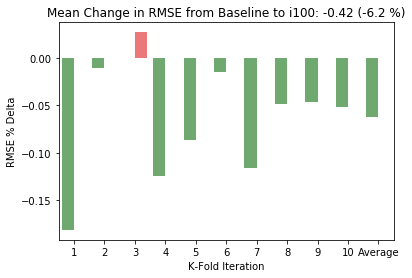

In [12]:
compare_i100_df = compare_train_iterations(train_results_baseline, train_results_i100)

#### Test Set: Check Generalization

In [13]:
test_results_i100 = fit_regression_test_eval(train_dframe = train_df,
                                             test_dframe = test_df,
                                             x_cols = ['RM', 'CRIM'],
                                             y_col = 'Price',
                                             iteration_name = 'i100')

test_results_list.append(test_results_i100)

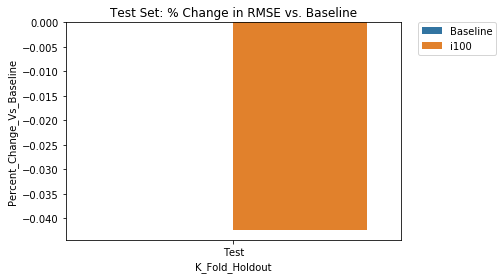

In [14]:
test_results_df = merge_list_of_dframes(test_results_list)
test_results_df = test_results_df.melt('K_Fold_Holdout', var_name='Iteration', value_name='RMSE')
test_results_df['Iteration_Name'] = [s.split('_')[1] for s in test_results_df['Iteration']]
baseline_rmse = test_results_df[test_results_df.Iteration == 'RMSE_Baseline']['RMSE']
test_results_df['Change_Vs_Baseline'] = [x - baseline_rmse for x in test_results_df['RMSE']]
test_results_df['Percent_Change_Vs_Baseline'] = [x / baseline_rmse for x in test_results_df['Change_Vs_Baseline']]
g = sns.barplot(x="K_Fold_Holdout", y="Percent_Change_Vs_Baseline", hue='Iteration_Name', data = test_results_df)
g.set(title = 'Test Set: % Change in RMSE vs. Baseline')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
display(tag)

## Model Iteration i200: Decide Whether or Not to Add Age Variable ('AGE')
#### Price ~ $\beta_{0}$ + $\beta_{1}$ $RM_{i}$ + $\beta_{1}$ $CRIM_{i}$ + $\beta_{2}$ $AGE_{i}$ + $\epsilon_{i}$

In [15]:
train_results_i200 = fit_regression_kfold_eval(dframe = train_df,
                                               x_cols = ['RM', 'CRIM', 'AGE'],
                                               y_col = 'Price',
                                               iteration_name = 'i200')

#### Training Set: Compare to Previous Iteration & Make Decision

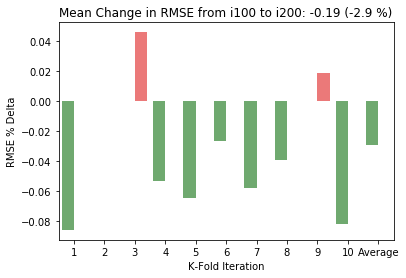

In [16]:
compare_i200_df = compare_train_iterations(train_results_i100, train_results_i200)

#### Test Set: Check Generalization

In [17]:
test_results_i200 = fit_regression_test_eval(train_dframe = train_df,
                                             test_dframe = test_df,
                                             x_cols = ['RM', 'CRIM', 'AGE'],
                                             y_col = 'Price',
                                             iteration_name = 'i200')
test_results_list.append(test_results_i200)

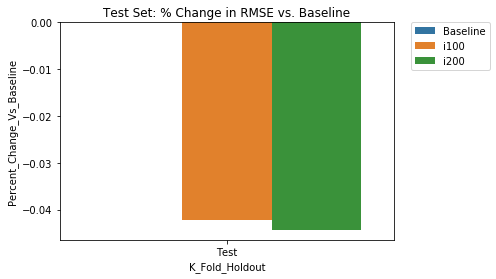

In [18]:
test_results_df = merge_list_of_dframes(test_results_list)
test_results_df = test_results_df.melt('K_Fold_Holdout', var_name='Iteration', value_name='RMSE')
test_results_df['Iteration_Name'] = [s.split('_')[1] for s in test_results_df['Iteration']]
baseline_rmse = test_results_df[test_results_df.Iteration == 'RMSE_Baseline']['RMSE']
test_results_df['Change_Vs_Baseline'] = [x - baseline_rmse for x in test_results_df['RMSE']]
test_results_df['Percent_Change_Vs_Baseline'] = [x / baseline_rmse for x in test_results_df['Change_Vs_Baseline']]
g = sns.barplot(x="K_Fold_Holdout", y="Percent_Change_Vs_Baseline", hue='Iteration_Name', data = test_results_df)
g.set(title = 'Test Set: % Change in RMSE vs. Baseline')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
display(tag)

## Model Iteration i300: Decide Whether or Not to Add Zone Variable ('ZN')
#### Price ~ $\beta_{0}$ + $\beta_{1}$ $RM_{i}$ + $\beta_{1}$ $CRIM_{i}$ + $\beta_{2}$ $AGE_{i}$ + $\beta_{3}$ $ZN_{i}$ + $\epsilon_{i}$

In [19]:
train_results_i300 = fit_regression_kfold_eval(dframe = train_df,
                                               x_cols = ['RM', 'CRIM', 'AGE', 'ZN'],
                                               y_col = 'Price',
                                               iteration_name = 'i300')

#### Training Set: Compare to Previous Iteration & Make Decision

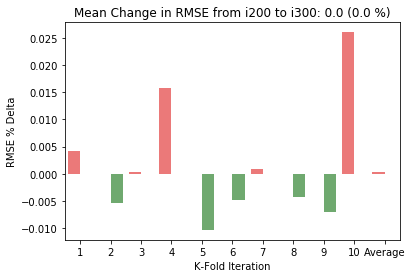

In [20]:
compare_i300_df = compare_train_iterations(train_results_i200, train_results_i300)

#### Test Set: Check Generalization

In [21]:
test_results_i300 = fit_regression_test_eval(train_dframe = train_df,
                                             test_dframe = test_df,
                                             x_cols = ['RM', 'CRIM', 'AGE', 'ZN'],
                                             y_col = 'Price',
                                             iteration_name = 'i300')

test_results_list.append(test_results_i300)

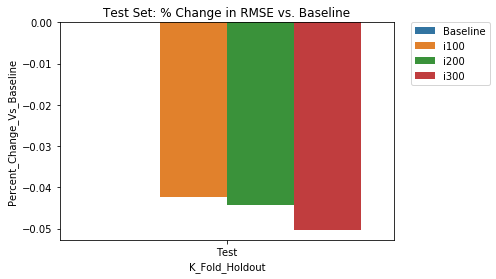

In [22]:
test_results_df = merge_list_of_dframes(test_results_list)
test_results_df = test_results_df.melt('K_Fold_Holdout', var_name='Iteration', value_name='RMSE')
test_results_df['Iteration_Name'] = [s.split('_')[1] for s in test_results_df['Iteration']]
baseline_rmse = test_results_df[test_results_df.Iteration == 'RMSE_Baseline']['RMSE']
test_results_df['Change_Vs_Baseline'] = [x - baseline_rmse for x in test_results_df['RMSE']]
test_results_df['Percent_Change_Vs_Baseline'] = [x / baseline_rmse for x in test_results_df['Change_Vs_Baseline']]
g = sns.barplot(x="K_Fold_Holdout", y="Percent_Change_Vs_Baseline", hue='Iteration_Name', data = test_results_df)
g.set(title = 'Test Set: % Change in RMSE vs. Baseline')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
display(tag)

## <font color='red'>Note!!!</font>
### If you would have made a decision based on the test set, you would have made the model more complex without any added performance...